In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

from astropy.table import Table as ApTable
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import scarlet

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("scarlet")
dlogger.setLevel(logging.INFO)

In [60]:
idx = 3
datapath = '/Users/fred/lsst/code/testdata_deblender/sim_data/psf_matched_sim'
data = np.load(os.path.join(datapath, 'images_{0}.npz'.format(idx)))
img = data["images"]
filters = data["filters"]
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
coords = np.unique(catalog['y','x'])

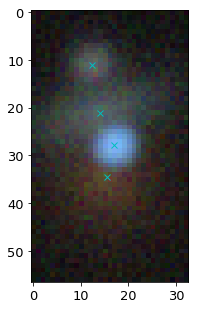

In [61]:
vmin = np.min(img)
vmax = 100
display.plotColorImage(images=img, filterIndices=[3,2,1], Q=8, show=False, figsize=(5,5), vmin=vmin, vmax=vmax)
for src in coords:
    plt.plot(src["x"], src["y"], 'cx')
plt.show()

In [62]:
import imp
imp.reload(scarlet)
imp.reload(scarlet.source)
imp.reload(scarlet.blend)
imp.reload(scarlet.operators)
imp.reload(scarlet.transformations)
imp.reload(scarlet)

<module 'scarlet' from '/Users/fred/lsst/code/scarlet/scarlet/__init__.py'>

In [69]:
bg_rms = np.array([np.sqrt(np.mean(_img)**2 + np.std(_img)**2) for _img in img])
#constraints = {"S": None, "m": {'use_nearest': True}, "+":None, "l0": 10}
constraints = {"S": None, "m": {'use_nearest': False}, "+":None, "l0": 1}
#constraints = {"S": None, "m": {'use_nearest': False}, "+":None}
#constraints = {"S": None, "m": {'use_nearest':True}, "+":None, "l0": 10}
#constraints = {"S": None, "M": False, "+": None}
#constraints = {"S": None, "+": None}
#constraints = {"S": None, "M": False, "m":.1, "+":None}
init_shape = (img.shape[0],)+(15,15)
sources = [scarlet.Source((coord["y"],coord["x"]), init_shape, constraints=constraints, K=2) for coord in coords]
from scarlet.source import InitMethod
blend = scarlet.blend.Blend(sources, img, bg_rms=bg_rms/10)#, init_method=InitMethod.PEAK)#, init_method=InitMethod.SYMMETRIC)

In [70]:
blend.fit(20)
blend.remove_degenerate_components(1e-4)
blend.fit(40)
blend.remove_degenerate_components(1e-4)
blend.fit(180)

INFO:scarlet.blend:resizing source 0 from (17,13) to (27,23) at it 10
INFO:scarlet.blend:max height: 93, width:43
INFO:scarlet.blend:resizing source 1 from (37,27) to (47,37) at it 10
INFO:scarlet.blend:max height: 73, width:39
INFO:scarlet.blend:resizing source 2 from (31,23) to (41,33) at it 10
INFO:scarlet.blend:max height: 59, width:35
INFO:scarlet.blend:resizing source 3 from (35,31) to (45,35) at it 10
INFO:scarlet.blend:max height: 71, width:35
INFO:scarlet.blend:resizing source 3 from (45,35) to (45,37) at it 20
INFO:scarlet.blend:max height: 71, width:37
INFO:proxmin:Completed 1 iterations
INFO:scarlet.blend:resizing source 1 from (47,37) to (47,39) at it 30
INFO:scarlet.blend:max height: 73, width:39
INFO:scarlet.blend:resizing source 3 from (45,37) to (56.25,37) at it 30
INFO:scarlet.blend:max height: 71, width:37
INFO:proxmin:Completed 11 iterations
INFO:proxmin:Completed 181 iterations


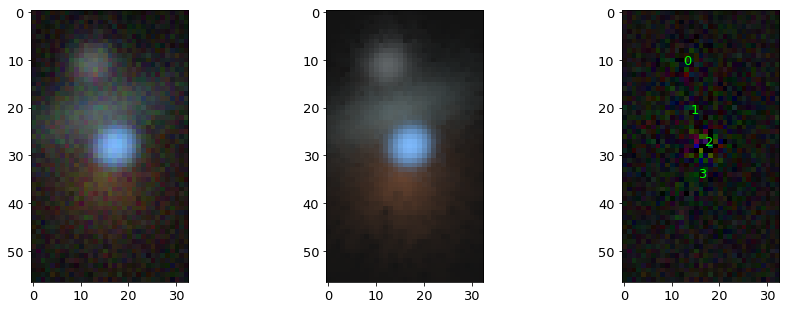

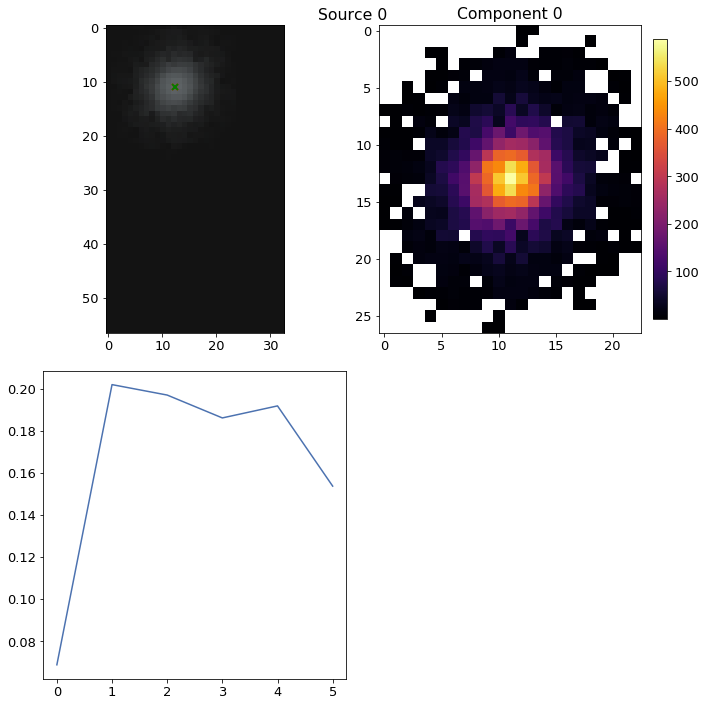

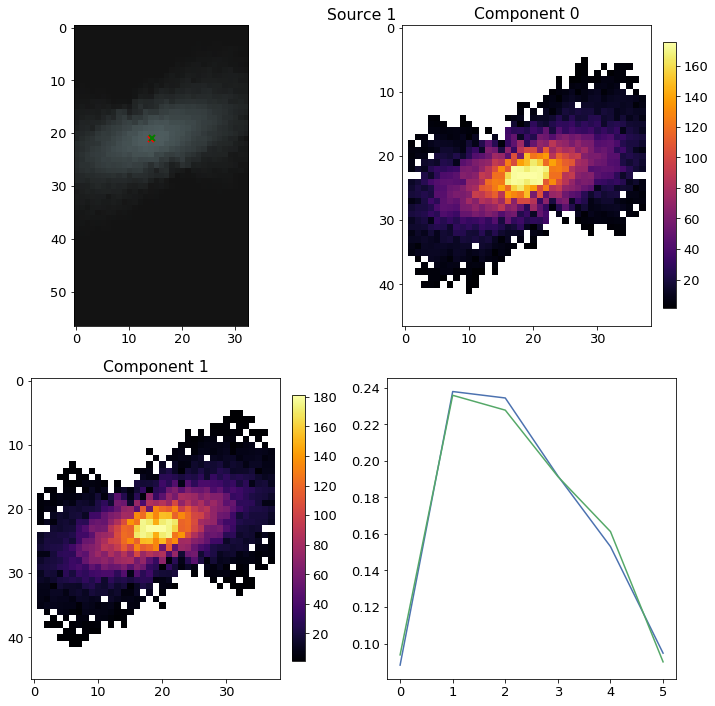

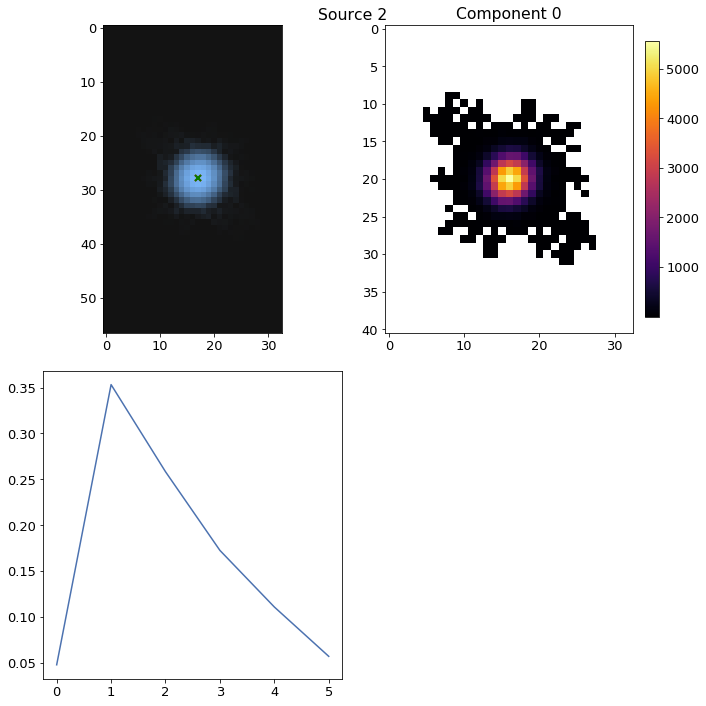

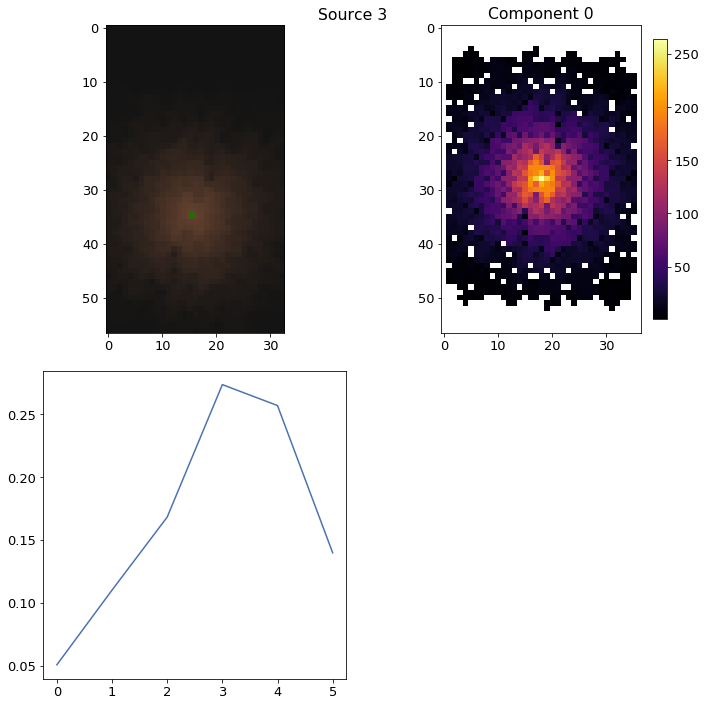

In [71]:
vmin = np.min(img)
vmax = 100

model = blend.get_model()
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
display.plotColorImage(images=img, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, ax=ax1, show=False)
display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax2)
display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax3)
#display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, show=False, ax=ax3)
for m,coord in enumerate(coords):
    plt.text(coord["x"], coord["y"], str(m), color="lime")
plt.show()

full_model = np.zeros_like(model)
for m in range(len(coords)):
    model = blend.get_model(m=m)
    full_model += model
    sources = blend.sources[m].K
    rows = np.ceil((sources+2)/2)
    fig = plt.figure(figsize=(10,5*rows))
    ax = [fig.add_subplot(rows,2, n+1) for n in range(sources+2)]
    display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax, ax=ax[0])
    #display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin*0, vmax=vmax/20)
    ax[0].plot(coords["x"][m], coords["y"][m], 'rx', mew=2)
    y,x = blend.sources[m].center
    #ax1.scatter(x,y,s=80,facecolor='none',edgecolor='r')
    ax[0].plot(x, y, 'gx', mew=2)
    src = blend.sources[m]
    for k in range(src.K):
        morph = src.morph[k].reshape(src.Ny,src.Nx)
        im = ax[k+1].imshow(np.ma.array(morph, mask=morph==0))
        ax[k+1].set_title("Component {0}".format(k))
        fig.colorbar(im, ax=ax[k+1],fraction=0.046, pad=0.04)
    for n,sed in enumerate(src.sed):
        ax[-1].plot(sed, label="Component {0}".format(n))
    plt.suptitle("Source {0}".format(m))
    plt.tight_layout()
    plt.show()